# Constructing dynamic collaboration networks and calculating social capital using IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to the second chapter of our exploration into how social networks shape the careers of filmmakers. Our end goal is to find out whether connections with network brokers—those pivotal individuals who link separate creative circles—significantly boost the careers of movie directors, and importantly, if these benefits are experienced differently by women and men.

**What are we aiming to do?**

Building on the groundwork laid in `Phase_1_Tracking_Movie_Directors_Career.ipynb`, where we cataloged films from 2000 to 2023, we now shift our attention to constructing dynamic networks of filmmakers and calculating their annual brokerage scores within these networks over this period. We'll utilize tools such as pandas for data handling, matplotlib and plotly for visualization, networkx for network analysis, and multiprocessing to handle computations efficiently.

First thing first, what do we mean by 'brokerage'? Network scientists use this term to describe the role of individuals who act as bridges between different groups or clusters of people within a network. These brokers are vital because they enable the flow of information and resources across the network, thereby creating new opportunities for other people and enhancing brokers' own influence and access to diverse resources. This ability to connect disparate groups makes brokerage a powerful form of social capital—a valuable asset in any industry, particularly in filmmaking, where success often depends on collaboration and the timely exchange of ideas.

Second, how do we measure someone's levels of brokerage social capital? We'll use three key metrics: 
- **Constraint**, which shows how much a person's contacts are connected to each other. Lower constraint indicates that a person has fewer redundant connections and more unique contacts, suggesting greater brokerage potential.
- **Effective size**, which measures the number of useful non-redundant connections an individual has. A higher effective size means a broader reach within the network.
- **Local clustering**, which assesses how closely connected an individual's immediate contacts are to each other. Lower clustering indicates that the individual is likely the sole link between different groups, enhancing their brokerage role.

In later analysis, we will analyze how a director's and their collaborators' brokerage scores might influence that director's career longevity and productivity. 

**How do we manage massive network data?**

Imagine a vast network of nearly 100,000 individuals with potential connections reaching nearly 5 billion in a single year. Over 23 years, this grows to more than 100 billion potential connections. This staggering complexity stems from the fact that relationship between the number of people and potential connections is quadratic—meaning as more individuals join, the potential for new connections increases exponentially, because each newcomer can in theory connect with all the existing members. 

To handle this vast amount of data efficiently, we will use parallel processing. Initially, we'll test our methods on a smaller, simulated network that mirrors real-world conditions, ensuring our approaches are solid before applying them to the full dataset.

**Our approach to network analysis:**

1. Who are we including in the network?

We will include people in key creative roles—directors, producers, writers, editors, cinematographers, production designers, and composers—people who significantly shape the narrative and artistic direction of a movie.

2. How do we define a connection?

Using a three-year rolling window, we consider filmmakers to be connected if they have collaborated within the last three years, allowing us to capture the dynamic nature of professional relationships.

3. How do we map a network that is ever changing?

Collaboration networks are in constant flux: some people enter the industry, some people leave it. We capture these shifts by constructing and analyzing 21 sequential network graphs, each covering a span of three years. This approach allows us to assess the current social capital of individuals based on their connections in the previous three years.

4. How do we measure brokerage social capital?

We evaluate the reach and influence of filmmakers within these networks using three key metrics: constraint, effective size, and local clustering. These measures provide insights into the networking prowess of industry professionals annually.

**Looking ahead**

By the end of this notebook, we will have calculated the annual brokerage scores for every key creative professional in our dataset from 2003 to 2023. This prepares us for the subsequent phase of our research, where we'll explore whether and how the social capital of a director's collaborators predicts the director's career outcomes.

# Identifying creative workers in the film industry (2000-2023)

In this segment, we'll pinpoint the key creative personnel behind the movies released between 2000 and 2023. These individuals represent the nodes in our collaboration networks. We're drawing from two datasets:
- `movies_2000_2023.csv`: a dataset we compiled in the earlier phase `Phase_1_Tracking_Movie_Directors_Career.ipynb`, which documents films released over the last 23 years. 
- `title.principals.tsv.gz`: A comprehensive IMDb dataset detailing the key personnel involved in these productions.

By the end of this segment, we'll have created the `movies_collaborations_2000_2023` dataset. Here's what it includes:
- Movie ID (`tconst`): A unique identifier for each film.
- Person ID (`nconst`): Unique identifiers for each creative worker invovled in these films.
- Role (`category`): This specifies the role each person played, be it director, producer, writer, editor, cinematographer, production designer, or composer.
- Movie Release Year (`startYear`):  The release year of each film.

From this data, we can see who worked with whom, in which capacity, and when, enabling us to build the collaboration networks over time.

In [3]:
# imports libraries
import pandas as pd # data handling and analysis
import os # interacting with the computer's operating system
import itertools # working with sequences of data
import networkx as nx # network analysis
import random # generate random numbers or selecting random elements
from collections import deque # keeping track of a list of items
import multiprocessing as mp # allowing tasks to be done simultaneously, speeding up computing processes
import pickle # saving and loading Python objects to and from files
import matplotlib.pyplot as plt # visualizing data
import numpy as np # dealing with numerical data and calculations
import plotly.graph_objects as go # producing interactive visualizations
import plotly.io as pio # exporting and displaying interactive visualizations

# Setting the working directory to ensure file paths are accessed correctly
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [15]:
# Loading the dataset of movies released from 2000 to 2023 created previously
movies_2000_2023 = pd.read_csv('movies_2000_2023.csv')

# Displaying the initial rows of the movies dataset to verify correct data loading and format
movies_2000_2023.head()

,tconst,startYear,genres
0,tt0011801,2019.0,"Action,Crime"
1,tt0013274,2021.0,Documentary
2,tt0015414,2000.0,\N
3,tt0028248,2022.0,Musical
4,tt0035423,2001.0,"Comedy,Fantasy,Romance"


So the data we are starting with contains all movies released between 2000 and 2023, with each row representing each movie, along with the following info: movie ID (`tconst`), release year (`startYear`), and genres (`genres`). From here, we can get the creative workers involved in these movies using IMDb's principals data.

In [4]:
# Load the IMDb dataset containing information about key personnel (principals) in movie productions 
# This is to identify creative workers in each film released between 2000 and 2023
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

# Filter the principals dataset to include only those in creative roles
creative_roles = ['director', 'producer', 'writer', 'editor', 'cinematographer', 'production_designer', 'composer']
df_principals = df_principals[df_principals['category'].isin(creative_roles)]

# Merge the movies dataset with the filtered principals dataset
# This creates a dataset linking movies released between 2000 and 2023 with the creative personnel involved
movies_collaborations_2000_2023 = df_principals[['tconst', 'nconst', 'category']].merge(movies_2000_2023[['tconst', 'startYear']], on='tconst', how='inner')

# Save the merged dataset to a CSV file
movies_collaborations_2000_2023.to_csv('movies_collaborations_2000_2023.csv' , index=False)

In [6]:
# Displaying the initial rows of the merged dataset to ensure the correct merging of movie and personnel data
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


With the `movies_collaborations_2000_2023` data, we have a bipartite network (also called a two-mode network), with each row signifying a link between a creative worker (`nconst`)and a movie (`tconst`), indicating their involvement in that particular movie.

In [7]:
# Calculating and displaying the number of unique movies and creative workers to understand the scope of the dataset
movies_collaborations_2000_2023.nunique()

tconst       296524
nconst       571851
category          7
startYear        24
dtype: int64

Our network comprise 571,851 creative workers who worked on 296,524 movies. Let's count the number of movies and creative personnel, as well as the average size of the creative team per movie for each year. This gives us a sense of the industry's scope and the scale of collaboration over time.

In [18]:
# Aggregating the data by release year count the unique number of movies and creative personnel by year
count_movies_people = movies_collaborations_2000_2023.groupby('startYear').agg(
    num_movies=('tconst', pd.Series.nunique),
    num_creative_workers=('nconst', pd.Series.nunique)
)

# Calculate the average team size by year to gauge collaboration scale
# Group by release year and movie id to count the unique number of people involved in each movie
creative_team_size = movies_collaborations_2000_2023.groupby(['startYear', 'tconst']).nconst.nunique()
# Group by release year again and calculate the average size of these teams for each year
average_creative_team_size = creative_team_size.groupby('startYear').mean().rename('average_creative_team_size')

# Merge the counts and average team size into a single dataframe for analysis
summary_df = pd.merge(count_movies_people, average_creative_team_size, on='startYear').reset_index()

In [19]:
# Displaying the summary DataFrame to review the data on movie production and creative team dynamics from 2000 to 2023.
summary_df

,startYear,num_movies,num_creative_workers,average_creative_team_size
0,2000.0,4919,17914,4.313275
1,2001.0,5337,19201,4.266254
2,2002.0,5496,20038,4.269651
3,2003.0,5698,21288,4.316076
4,2004.0,6321,23662,4.325107
5,2005.0,7225,26717,4.261730
6,2006.0,7859,29483,4.300674
7,2007.0,8461,31641,4.252807
8,2008.0,9879,36051,4.172183
9,2009.0,11330,40796,4.101236


Let's create bar charts to visualize trends in the number of movies, the number of people involved, and the average team size across the years.

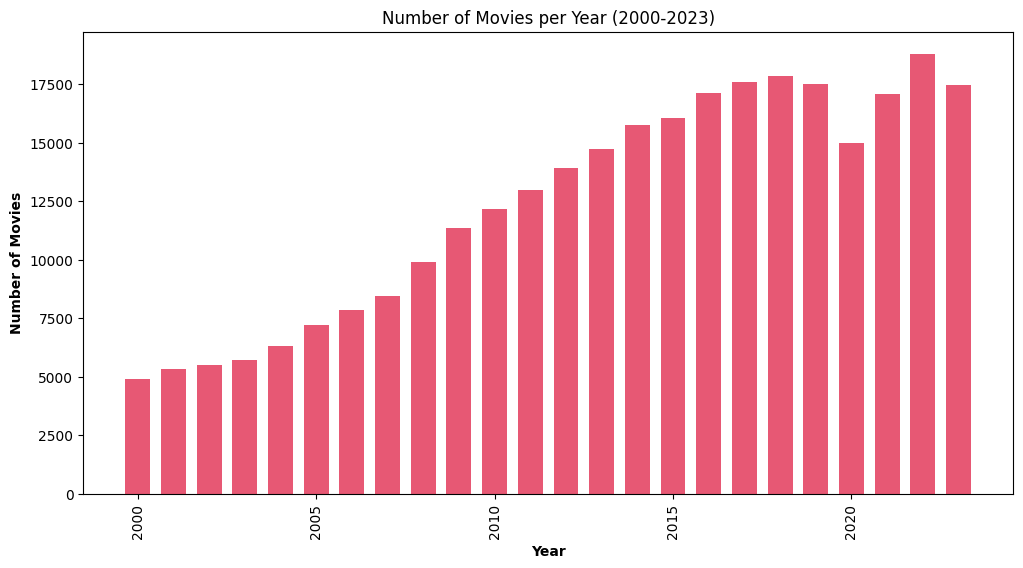

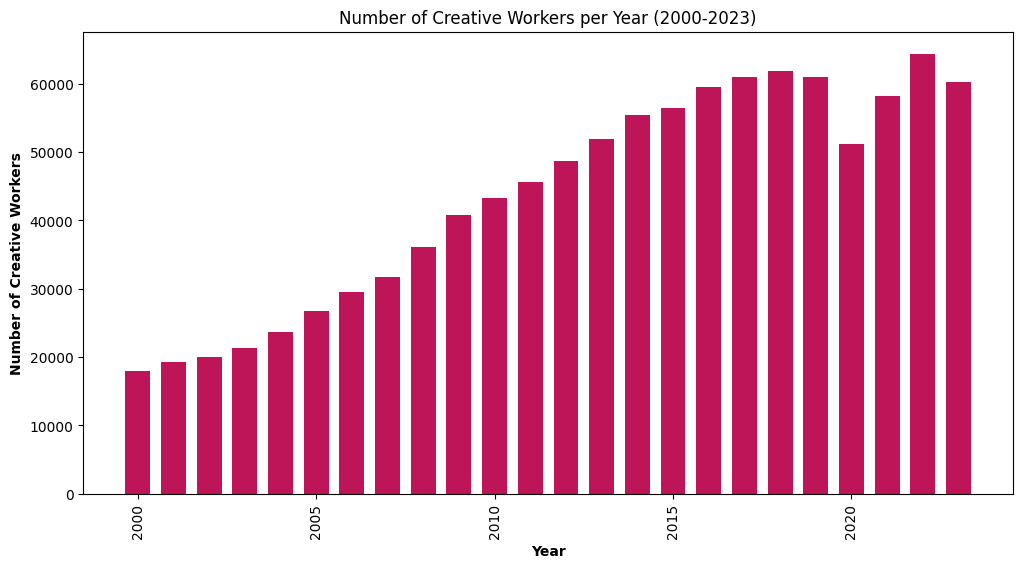

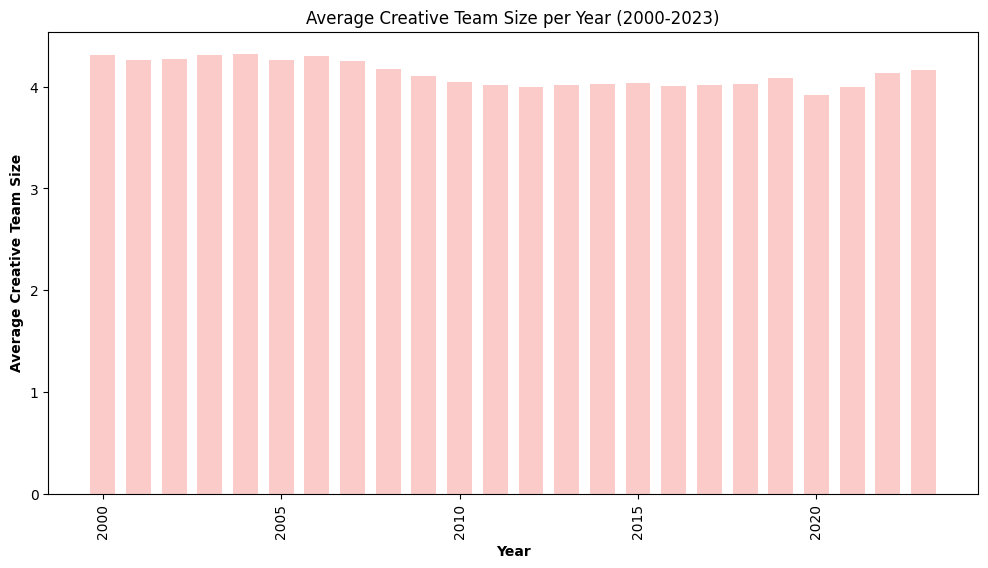

In [21]:
# Visualize the number of movies per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_movies'], color='#e75874', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.title('Number of Movies per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the number of people (creative personnel) per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_creative_workers'], color='#be1558', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Creative Workers', fontweight='bold')
plt.title('Number of Creative Workers per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the average team size per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['average_creative_team_size'], color='#fbcbc9', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Creative Team Size', fontweight='bold')
plt.title('Average Creative Team Size per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

The overall trend shows a significant increase in both the number of movies and the number of creative personnel, highlighting an expanding industry. However, there was a noticeable dip in 2020, likely due to the disruptions caused by the Covid-19 pandemic, with a swift recovery by 2022.

Interestingly, the average size of the creative teams remains relatively constant, suggesting a stable collaboration pattern despite the industry's growth.

# Understanding Network Evolution Through Moving Windows

As we use a three-year moving window to analyze the yearly brokerage social capital of filmmakers, understanding the evolution of this network is crucial. Thus, let's calculate the number of movies, people, and potential connections for each 21 three-year periods starting from 2000-2002 up to 2020-2022:

In [ ]:
# Initialize a list to store counts for each 3-year moving window
window_counts = []

# Loop through each year to calculate the counts for each 3-year moving window
for year in range(2003, 2024):  # From 2003 to 2023
    start_year = year - 3  # Start of the 3-year window
    end_year = year - 1    # End of the 3-year window

    # Filter the data for the current window
    window_data = movies_collaborations_2000_2023[
        movies_collaborations_2000_2023['startYear'].between(start_year, end_year)
    ]

    # Count the unique number of movies and people in the window
    num_movies = window_data['tconst'].nunique()
    num_people = window_data['nconst'].nunique()

    # Append the counts to the list
    window_counts.append({
        'Window Start': start_year,
        'Window End': end_year,
        'Number of Movies': num_movies,
        'Number of People': num_people
    })

# Convert the list of counts into a DataFrame
window_counts_df = pd.DataFrame(window_counts)

# Calculate potential connections for each window
window_counts_df['Potential Connections'] = window_counts_df['Number of People'].apply(lambda n: n * (n - 1) / 2)

In [10]:
window_counts_df

,Window Start,Window End,Number of Movies,Number of People,Potential Connections
0,2000,2002,15752,47308,1.119000e+09
1,2001,2003,16531,50348,1.267435e+09
2,2002,2004,17515,54554,1.488042e+09
3,2003,2005,19244,60562,1.833848e+09
4,2004,2006,21405,67372,2.269460e+09
5,2005,2007,23545,73952,2.734412e+09
6,2006,2008,26199,81723,3.339284e+09
7,2007,2009,29670,91552,4.190839e+09
8,2008,2010,33376,101591,5.160315e+09
9,2009,2011,36485,109737,6.021050e+09


Let's graph these counts to visualize the size of the creative network across different time periods.

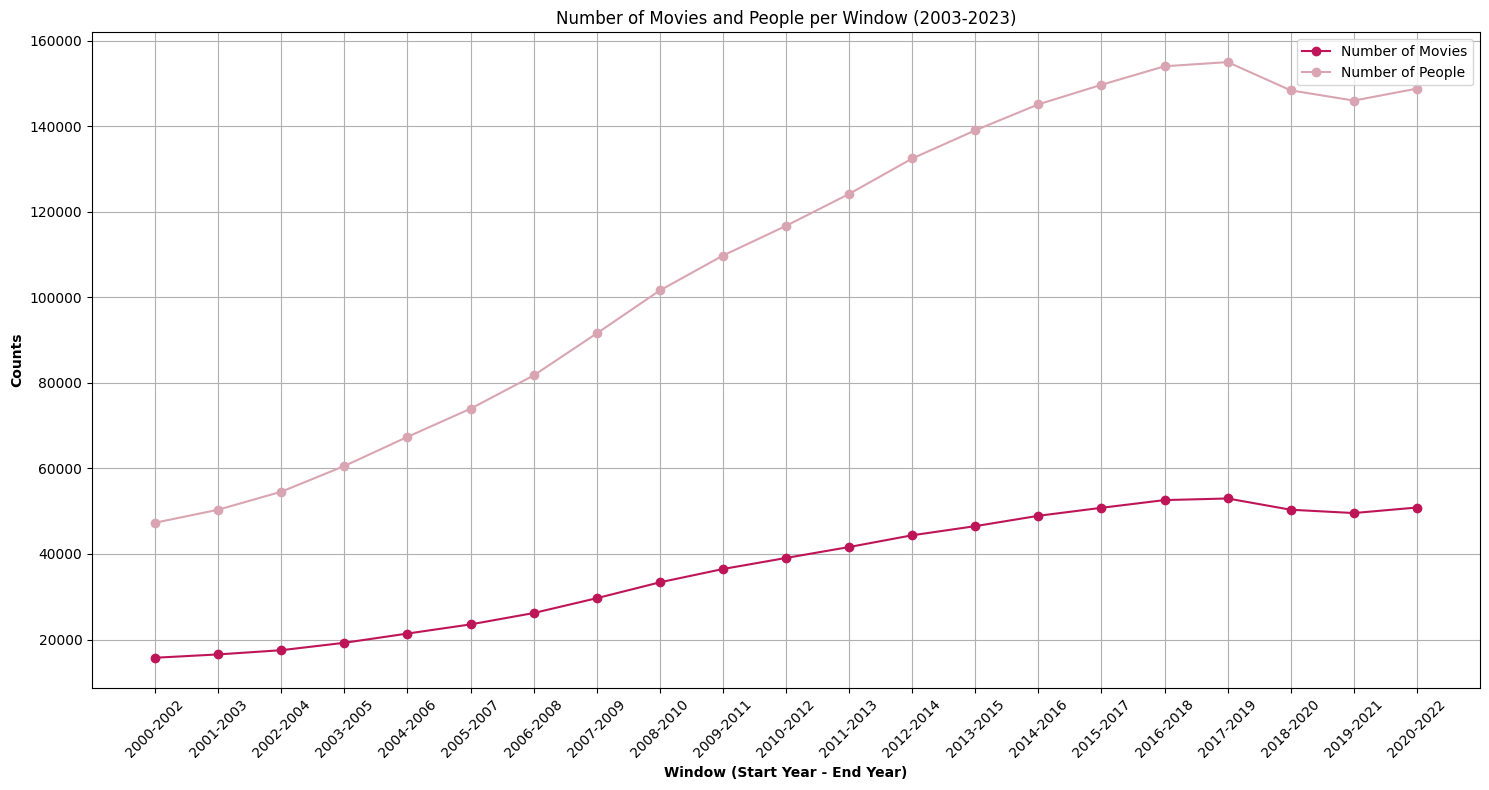

In [13]:
# Visualize the number of movies and people in each 3-year moving window using a line graph
# Set positions of the line points
r1 = np.arange(len(window_counts_df))

# Create the line plots
plt.figure(figsize=(15, 8))
plt.plot(r1, window_counts_df['Number of Movies'], marker='o', color='#be1558', label='Number of Movies')
plt.plot(r1, window_counts_df['Number of People'], marker='o', color='#d9a5b3', label='Number of People')

# Add xticks on the middle of the point groups
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)

# Create legend & Show graphic
plt.legend()
plt.title('Number of Movies and People per Window (2003-2023)')
plt.tight_layout()
plt.grid(True)
plt.show()


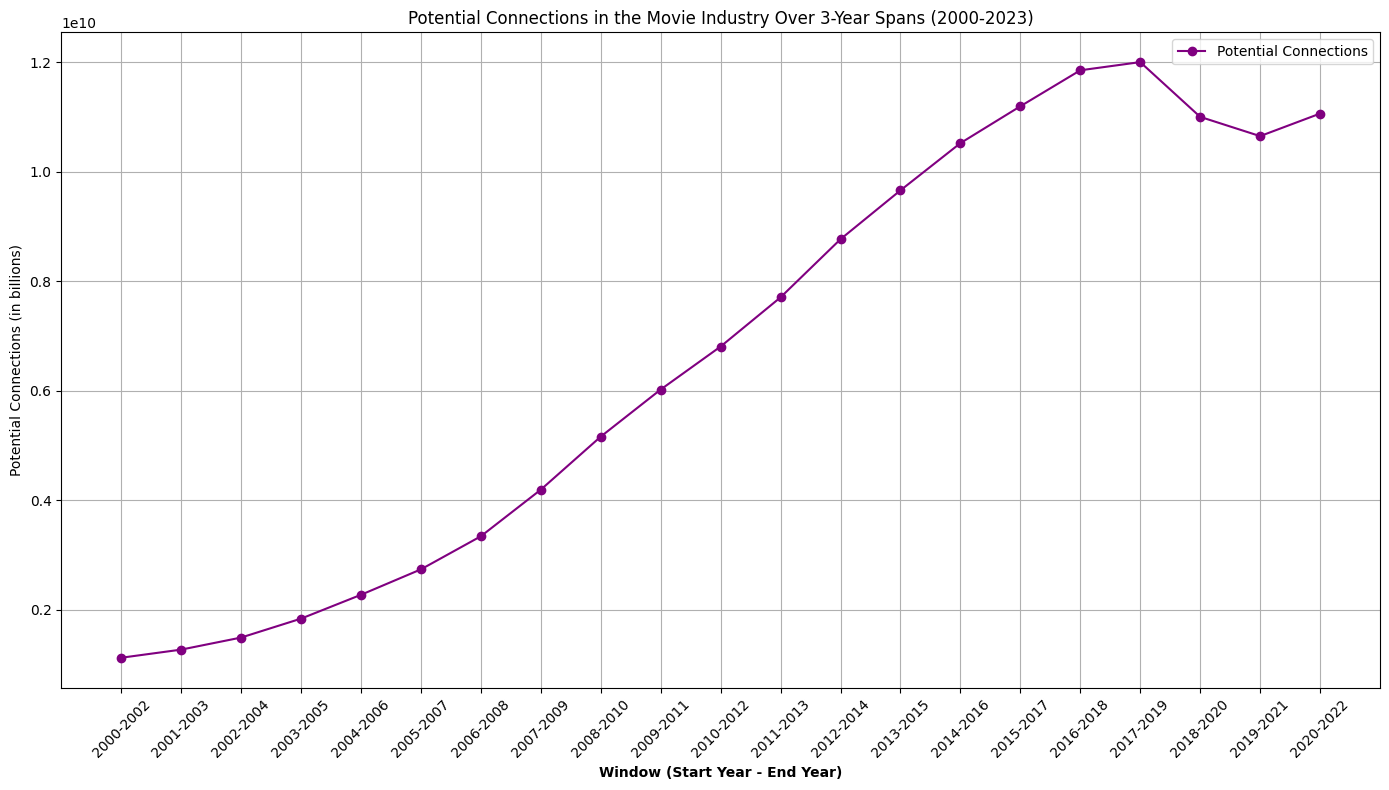

In [15]:
# Set positions of the line points
r1 = np.arange(len(window_counts_df))

# Plotting the potential connections over time with custom x-axis labels
plt.figure(figsize=(14, 8))
plt.plot(r1, window_counts_df['Potential Connections'], marker='o', color='purple', label='Potential Connections')
plt.title('Potential Connections in the Movie Industry Over 3-Year Spans (2000-2023)')
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Potential Connections (in billions)')

# Set x-ticks to display 'Start Year - End Year' format
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The smallest network appeared in the 2000-2002 window, with 47,308 creative workers, and the largest in the 2017-2019 window, with 154,952 workers.

The number of potential connections in our analysis windows is astounding, reaching a peak of approximately 12 billion during the 2017-2019 period. This illustrates the quadratic relationship between the number of people and potential connections in a network. As each new individual joins the network, the possibilities for new connections multiply exponentially; every new member has the potential to link with all previously existing members.

Before we dive deeper into the construction and analysis of our networks, I'm curious about the distribution of roles over time. Let's visualize this using donut charts showing the proportion of creative professionals who are directors, writers, composers, etc. 

In [4]:
# Define a function to categorize years into decades
def categorize_decade(year):
    if 2000 <= year <= 2009:
        return "2000-2009"
    elif 2010 <= year <= 2019:
        return "2010-2019"
    elif 2020 <= year <= 2023:
        return "2020-2023"
    else:
        return None

# Apply the categorization function to create a new 'Decade' column
movies_collaborations_2000_2023['Decade'] = movies_collaborations_2000_2023['startYear'].apply(categorize_decade)

# Group by 'Decade' and 'Category' and count occurrences
decade_role_counts = movies_collaborations_2000_2023.groupby(['Decade', 'category']).size().reset_index(name='Count')

# Calculate the total counts per decade for normalization
decade_totals = decade_role_counts.groupby('Decade')['Count'].sum().reset_index(name='Total')

# Merge the counts with totals to calculate percentages
decade_role_percentage = decade_role_counts.merge(decade_totals, on='Decade')
decade_role_percentage['Percentage'] = (decade_role_percentage['Count'] / decade_role_percentage['Total']) * 100

# Check the calculated percentages
decade_role_percentage.sort_values(by=['Decade', 'Percentage'], ascending=False)


,Decade,category,Count,Total,Percentage
16,2020-2023,director,70880,277303,25.560488
18,2020-2023,producer,61393,277303,22.139321
14,2020-2023,cinematographer,40540,277303,14.619387
20,2020-2023,writer,39074,277303,14.090724
15,2020-2023,composer,35595,277303,12.836140
17,2020-2023,editor,26075,277303,9.403072
19,2020-2023,production_designer,3746,277303,1.350869
9,2010-2019,director,165022,627544,26.296483
11,2010-2019,producer,126352,627544,20.134365
7,2010-2019,cinematographer,90485,627544,14.418909


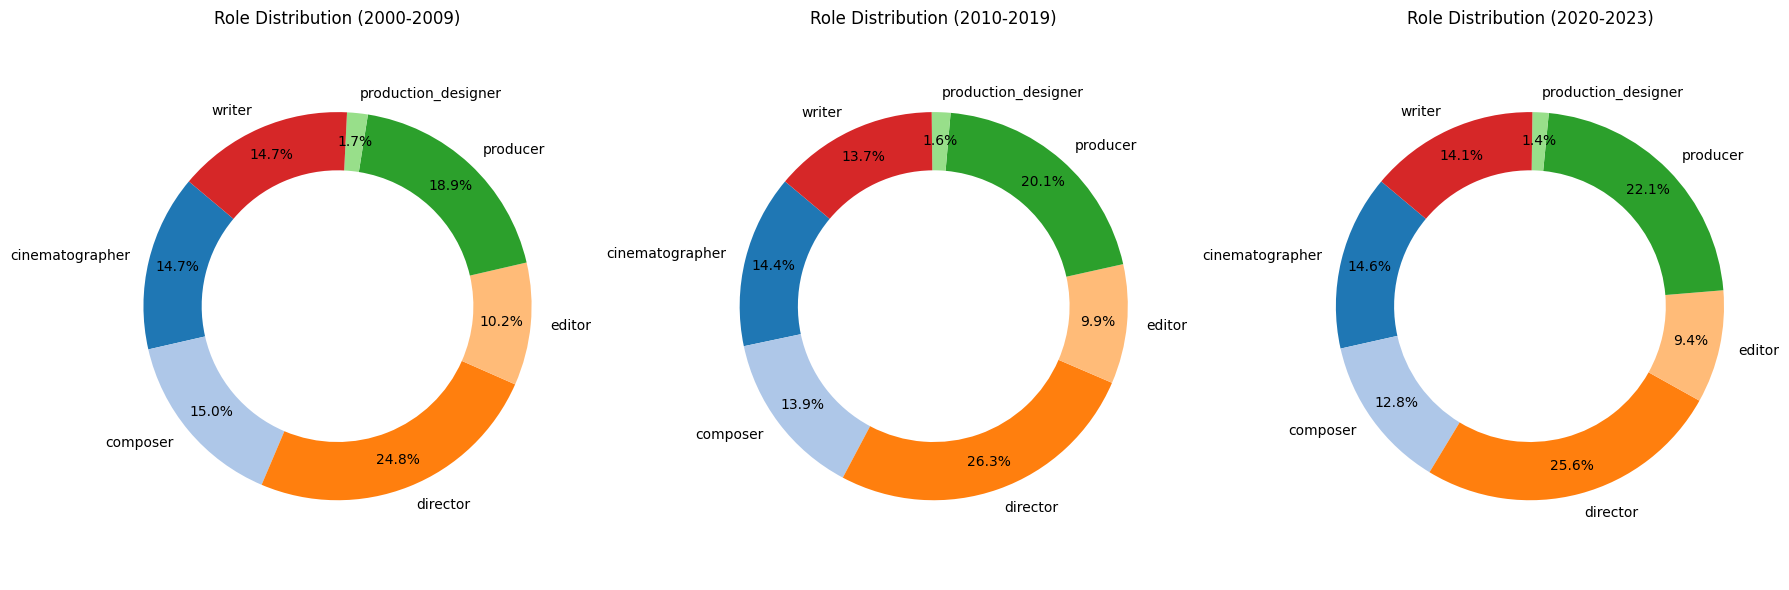

In [5]:
# Function to plot all donut charts side by side using wedgeprops
def plot_all_donut_charts_side_by_side(data):
    # Define the decades
    decades = ["2000-2009", "2010-2019", "2020-2023"]
    colors = plt.cm.tab20.colors  # Define a common color scheme for consistency

    # Create a figure with 3 subplots (axes)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Loop through each decade and plot on respective ax
    for ax, decade in zip(axes, decades):
        # Filter the data for the specified decade
        decade_data = data[data['Decade'] == decade]
        
        # Plotting the donut chart using wedgeprops
        wedges, texts, autotexts = ax.pie(
            decade_data['Percentage'], labels=decade_data['category'], autopct='%1.1f%%',
            startangle=140, pctdistance=0.85, colors=colors,
            wedgeprops={'width': 0.3}  # Adjust the width to create donut shape
        )

        # Set aspect ratio to ensure pie is drawn as a circle
        ax.axis('equal')
        ax.set_title(f'Role Distribution ({decade})')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the combined plot
    plt.show()

# Plot all donut charts side by side
plot_all_donut_charts_side_by_side(decade_role_percentage)

Despite the substantial growth in the industry from 2000 to 2023, the proportional representation of roles has remained remarkably stable, with directors have consistently held the largest share, followed by producers. Meanwhile, cinematographers, writers, and composers maintain a balanced share.

# Constructing dynamic collaboration network and calculating brokerage social capital 

With our exploration of creative roles complete, let’s shift our focus to the main task of this notebook: building the dynamic collaboration networks within the film industry and calculate the brokerage social capital for every creative worker involved. From there, we will later obtain the brokerage scores of the directors's collaborators, which will then be used to predict their career longevity.

**Implementing a Three-Year Moving Window**

We use a three-year moving window to calculate each person's brokerage social capital, examining their collaborations in the years leading up to the target year. For instance, to calculate the social capital for 2003, we look at collaborations from 2000 to 2002. Then, to calculate the social capital for 2004, we look at collaborations from 2001 to 2003, and so on. This method captures the evolving dynamics of the network, reflecting both the dissolution of old ties and the formation of new ones as we move through the timeline up to 2023.

**Transforming Data for Network Analysis**

Starting with our `movies_collaborations_2000_2023` dataset, which forms a bipartite network of movies and people, our task is to convert this into an edge list for each year. Each edge represents a collaboration between two individuals. We then aggregate edges from three consecutive years to construct a comprehensive network graph for each window, to which we can apply network analysis techniques to compute brokerage scores for everyone in the network.

**Automating and Accelerating the Calculation of Brokerage Social Capital**

Given the vast scale of our 21 networks, which encompass up to 150,000 individuals and potentially 12 billions of connections, manual analysis is not only impractical but also prone to errors. To streamline this process, let's create a function named `calculate_social_capital`. This function is designed to automate the construction of networks for each year from 2003 to 2023 by pulling collaboration data from the preceding three years and to compute several metrics of brokerage social capital:
- Constraint: How much a person’s network contacts are connected to each other, potentially limiting their brokerage opportunities.
- Effective Size: The number of unique, non-redundant connections a person has.
- Local Clustering: The extent to which a person’s network contacts tend to cluster together.


In [3]:
# Define a function to calculate various brokerage social capital metrics for a specified year and set of edges
# This function is placed in a separate Python script named "network_analysis_function.py" for parallel processing
def calculate_social_capital(year, edges_by_year):
    
    # Initialize a rolling window to accumulate edges over a 3-year period
    rolling_edges = deque()

    # For each year in the 3-year window leading up to the focal year, add the edges to the rolling window
    for y in range(year - 3, year):
        edges = edges_by_year.get(y, []) # Retrieve edges for the year 'y', defaulting to an empty list if not found
        rolling_edges.extend(edges) # Add these edges to the rolling window
    
    # Create a graph (network) using the edges accumulated in the rolling window
    G = nx.Graph()
    G.add_edges_from(rolling_edges) # Add the edges to the graph
    
    # Calculate brokerage scores for the nodes
    brokerage_scores = {
        # Constraint measures the extent to which a node's connections are to others that are connected to each other
        'constraint': nx.constraint(G), 
        # Effective size is a measure of the number of non-redundant contacts a node has
        'effective_size': nx.effective_size(G), 
        # Local clustering coefficient measures the degree to which nodes in a graph tend to cluster together
        'local_clustering': nx.clustering(G) 
    }
    return year, brokerage_scores

Now, we can apply this function to each window manually. But we can also speed up the total computation time with parallel processing. It's like an assembly line in a factory, where the task of constructing each network and computing social capital metrics for everyone in the network is distributed across multiple workers/processors. 

To optimize performance in the Jupyter Notebook environment—which is great for interactive analysis but struggles with intensive parallel processing—we externalize our main functions, `calculate_social_capital` and its wrapper `calculate_social_capital_wrapper`, into separate Python scripts (`network_analysis_function.py` and `parallel_functions.py`). This separation ensures that each processor can independently access and execute these functions without the typical limitations encountered within notebooks.

In [ ]:
# Wrapper function for parallel processing
# This function is placed in a separate Python script named "parallel_functions.py" for parallel processing
def calculate_social_capital_wrapper(year, edges_by_year):
    # Call the main function to calculate social capital metrics for a given year and its edges
    return calculate_social_capital(year, edges_by_year)

## Preparing Our Tools: Testing with a Simulated Network

Before diving into the vast ocean of our real-world data, let's dip our toes in a more controlled environment with a toy example. This simulated, scaled-down network mimics the complex interactions within the film industry, allowing us to refine our methods in a manageable setting.

Here are what we will do to construct our simulated miniature network:

1. *Setting Time Frame and Volume:*: We simulate a series of film productions from 2000 to 2006, with two productions per year. This time frame is compact yet sufficient to test the mechanics of our analysis tools without the overwhelming variability of a larger dataset.

2. *Populating the Network:* We populate this mini-universe with a set of 11 characters, including three key players who are more frequently involved across projects. This mirrors real-world scenarios where certain individuals are central to multiple projects.

3. *Generating Connections:* For each movie, a randomly chosen subset of our cast comes together. This randomness introduces the necessary variability that exists in real-world collaborations. We then create pairs from these selected individuals to represent collaborative ties, which are what we'll use to construct the networks.

4. *Visualizing Networks:* With our toy data in hand, we use Plotly and NetworkX to create dynamic visualizations that illustrate how these networks evolve over time.

5. *Restructuring the simulated data:* Finally, we transform the simulated data into a formet that mirrors our actual data (`movies_collaborations_2000_2023`), so that each row a link between a person (`nconst`)and a movie (`tconst`) along with the movie release year (`startYear`). This ensures our codes are applicable to our real data.

Let's get started!

In [3]:
# Create a toy example to test and validate the function before applying it to the real dataset

# Set a random seed for reproducibility of results
random.seed(1234) 

# Define the timeframe and structure of the toy dataset
years = range(2000, 2006) # Define the range of years for the simulation
movies_per_year = 2 # Define the number of simulated movies per year
people = ['person' + str(i) for i in range(1, 12)]  # Create a list of fictional people identifiers
key_players = ['person1', 'person2', 'person3']  # Define key players who appear more frequently

# Generate random collaborations within the defined structure
data = []
for year in years:
    for movie_number in range(1, movies_per_year + 1):
        movie_id = f"movie_{year}_{movie_number}" # Construct a unique movie identifier
        num_people = random.randint(4, 9)  # Choose a random number of people for variability
        selected_people = random.sample(people, num_people) # Randomly select people to be involved in the movie
        selected_people.extend(random.sample(key_players, 1))  # Ensure inclusion of at least one key player
        selected_people = list(set(selected_people))  # Remove any duplicate people
        # Create all possible pairs of collaborators to simulate their interactions
        for collaboration in itertools.combinations(selected_people, 2):
            data.append({'tconst': movie_id, 'startYear': year, 'nconst1': collaboration[0], 'nconst2': collaboration[1]})

# Convert the collaboration data into a DataFrame for easier manipulation
toy = pd.DataFrame(data)


Let's see what our toy data looks like:

In [58]:
toy

,tconst,startYear,nconst1,nconst2
0,movie_2000_1,2000,person6,person10
1,movie_2000_1,2000,person6,person7
2,movie_2000_1,2000,person6,person11
3,movie_2000_1,2000,person6,person8
4,movie_2000_1,2000,person6,person1
...,...,...,...,...
253,movie_2005_2,2005,person5,person8
254,movie_2005_2,2005,person5,person1
255,movie_2005_2,2005,person11,person8
256,movie_2005_2,2005,person11,person1


That's really hard to understand. Let's visualize our simulated network to see how it changes over time. For this, we'll use Plotly’s animation capabilities to create a smooth transition between yearly networks, showing how new connections form and old ones fade as people come together to create films. 

In [29]:
# Define a function to create a scatter plot for edges in the network visualization
def scatter_edges(G, pos):
    edge_x = []
    edge_y = []
    # Extract coordinates for each edge to plot
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None]) # X coordinates for each edge
        edge_y.extend([y0, y1, None]) # Y coordinates for each edge
    # Create and return a scatter plot object for the edges
    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
    return edge_trace

# Define a function to create a scatter plot for nodes in the network visualization
def scatter_nodes(pos, labels=None):
    # Ensure labels are properly formatted as strings
    if labels is None:
        labels = list(pos.keys())
    labels = [str(label) for label in labels]  # Convert all labels to strings

    x, y = zip(*pos.values()) # Unpack positions into separate lists
    # Create and return a scatter plot object for the nodes
    scatter = go.Scatter(
        x=x, y=y, 
        mode='markers+text', 
        text=labels,
        textposition="top center",
        marker=dict(size=10, color='LightSkyBlue'),
        hoverinfo='text'
    )
    return scatter


In [31]:
# Initialize graph object and dictionary for positions
G = nx.Graph()
pos = None

# Initialize an empty graph and a position dictionary
graphs_by_year = {}
for year in sorted(toy['startYear'].unique()):
    yearly_data = toy[toy['startYear'] == year]
    G.clear() # Clear the graph for new data
    G.add_edges_from(yearly_data[['nconst1', 'nconst2']].itertuples(index=False))
    
    # Position nodes in the graph using a spring layout for visual appeal
    if not pos:
        pos = nx.spring_layout(G, seed=42)  # Initial layout for consistency across frames
    else:
        new_nodes = set(G.nodes()) - set(pos.keys())
        if new_nodes:
            subgraph = G.subgraph(new_nodes)
            pos_new = nx.spring_layout(subgraph, seed=42)  # Layout for new nodes
            pos.update(pos_new)

    graphs_by_year[year] = nx.Graph(G) # Store the graph for the current year

# Prepare frames for animation showing the evolution of the network
frames = []
for year, graph in graphs_by_year.items():
    frame = go.Frame(
        data=[scatter_edges(graph, pos), scatter_nodes(pos, labels=graph.nodes())],
        name=str(year),
        layout=go.Layout(
            annotations=[{
                "text": f"Year: {year}",
                "xref": "paper",
                "yref": "paper",
                "showarrow": False,
                "x": 0.5,
                "y": -0.1,
                "xanchor": "center",
                "yanchor": "top",
                "font": {"size": 16}
            }]
        )
    )
    frames.append(frame)

# Define initial data and layout for the figure
fig = go.Figure(
    data=[scatter_edges(graphs_by_year[min(graphs_by_year)], pos),
          scatter_nodes(pos, labels=graphs_by_year[min(graphs_by_year)].nodes())],
    layout=go.Layout(
        showlegend=False,
        hovermode='closest',
        title="Network Evolution Over the Years",
        xaxis={"visible": False},  # Hide x-axis labels
        yaxis={"visible": False},  # Hide y-axis labels
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "y": 1.05,
            "x": 1.15,
            "xanchor": "right",
            "yanchor": "top",
            "pad": {"t": 0, "r": 10},
            "buttons": [{
                "label": 'Play',
                "method": 'animate',
                "args": [None, {
                    "frame": {"duration": 500, "redraw": True},
                    "fromcurrent": True,
                    "mode": 'immediate'
                }]
            }]
        }]
    ),
    frames=frames
)
# Display the interactive network visualization
fig.show()

In [63]:
# Save the interactive figure to HTML for easy sharing
pio.write_html(fig, file='simulated_dynamic_network.html', auto_open=True)

[Click here to view the dynamic network visualization we just created!](https://nhunguyen0901.github.io/SocialNetworks_CareerLongevity/simulated_dynamic_network.html) (GitHub doesn't directly render interactive JavaScript content such as Plotly graphs in its notebook viewer.)

Now, let's turn this network data into the format that mirrors our actual data, with each person's participation in a movie listed as separate entries rather than as pairs of collaborators. This ensures the codes we are about to write are applicable to our real data.

In [4]:
# Reshape the DataFrame to have all pairs in a single column
pairs_data = []
for _, row in toy.iterrows():
    pairs_data.append([row['tconst'], row['startYear'], row['nconst1']])
    pairs_data.append([row['tconst'], row['startYear'], row['nconst2']])

# Reformat the toy data into the final structure
toy = pd.DataFrame(pairs_data, columns=['tconst', 'startYear', 'nconst'])

# Remove duplicates
toy = toy.drop_duplicates()

In [5]:
toy

,tconst,startYear,nconst
0,movie_2000_1,2000,person10
1,movie_2000_1,2000,person8
3,movie_2000_1,2000,person1
5,movie_2000_1,2000,person2
7,movie_2000_1,2000,person7
...,...,...,...
487,movie_2005_2,2005,person3
489,movie_2005_2,2005,person5
491,movie_2005_2,2005,person9
493,movie_2005_2,2005,person1


## Testing the Toy Example with Parallel Processing

1. *Importing the function to calculate brokerage*: We start by importing the `calculate_social_capital_wrapper` function, a function crafted to facilitate the computation of social capital metrics efficiently across multiple processors. This function acts as a bridge, ensuring smooth execution of our main function, `calculate_social_capital`. 

2. *Building an edgelist for each year in the data*: We define the `create_pairs` function to generate a detailed list of collaborative ties for each group of participants by movie and year. This creates the input for our social capital calculation.

3. *Setting up parallel processing*: We initiate a multiprocessing pool, paralleling an assembly line where multiple workers (processors) handle different parts of the task concurrently. This significantly reduces computation time and enhances efficiency.

4. *Running the calculations*: Using pool.starmap, we execute our brokerage calculation across the defined years, ensuring each year's network is analyzed in parallel for speed and efficiency.

5. *Collecting and reviewing the Results*: After processing, we compile the brokerage scores for each year into a dictionary, `brokerage_scores_by_year`.

In [6]:
# Process the toy example data to calculate brokerage scores using parallel processing

# Import the wrapper function for calculating brokerage social capital for parallel processing
from parallel_functions import calculate_social_capital_wrapper 

# Define a function to create pairs of collaborators from the toy data
def create_pairs(group):
    # For each group of data, create all possible pairs of collaborators
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

# Main execution block
if __name__ == "__main__":
    # Group the toy data by movie and year, and apply the pair creation function
    toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year for the toy data
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in toy.groupby('startYear')}
    
    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process for the toy example
    years = range(2003, 2007)

    # Calculate brokerage scores for each year in parallel
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()
    
    # Collect the calculated brokerage scores by year
    brokerage_scores_by_year_toy = {year: scores for year, scores in results}

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1172/1350292465.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)


Let's review these scores to see whether our functions are performing as expected.

In [7]:
brokerage_scores_by_year_toy

{2003: {'constraint': {'person10': 0.359919675925926,
   'person8': 0.359919675925926,
   'person1': 0.359919675925926,
   'person2': 0.359919675925926,
   'person7': 0.36125000000000007,
   'person6': 0.359919675925926,
   'person11': 0.359919675925926,
   'person4': 0.359919675925926,
   'person3': 0.3639628105471727,
   'person9': 0.3639628105471727,
   'person5': 0.359919675925926},
  'effective_size': {'person10': 1.4000000000000004,
   'person8': 1.4000000000000004,
   'person1': 1.4000000000000004,
   'person2': 1.4000000000000004,
   'person7': 1.0,
   'person6': 1.4000000000000004,
   'person11': 1.4000000000000004,
   'person4': 1.4000000000000004,
   'person3': 1.0,
   'person9': 1.0,
   'person5': 1.4000000000000004},
  'local_clustering': {'person10': 0.9555555555555556,
   'person8': 0.9555555555555556,
   'person1': 0.9555555555555556,
   'person2': 0.9555555555555556,
   'person7': 1.0,
   'person6': 0.9555555555555556,
   'person11': 0.9555555555555556,
   'person4': 0

The `brokerage_scores_by_year_toy`dictionary contains the calculated brokerage scores by year for constraint, effective size, and local clustering for 11 people in our simulated network. These scores are available for the years 2003 through 2006. 

To make it easier to grasp how each individual's network position and influence evolved over these years, we can visualize these metrics over time. Let's do it for Person 1, Person 3 (two key players in our simulated network), Person 9, Person 10 (the regular folks). For this, we can create line graphs for each person where each graph will show the variation of constraint, effective size, and local clustering from 2003 to 2006. Key players (Persons 1 and 3) have more intense colors compared to other individuals (Persons 7 and 10) for each metric, allowing for an easy visual distinction of their network positions and influence  over time.

These visual distinctions help emphasize the differences in network positions and influence between key players and other members, showcasing how each individual's metrics evolve over time.

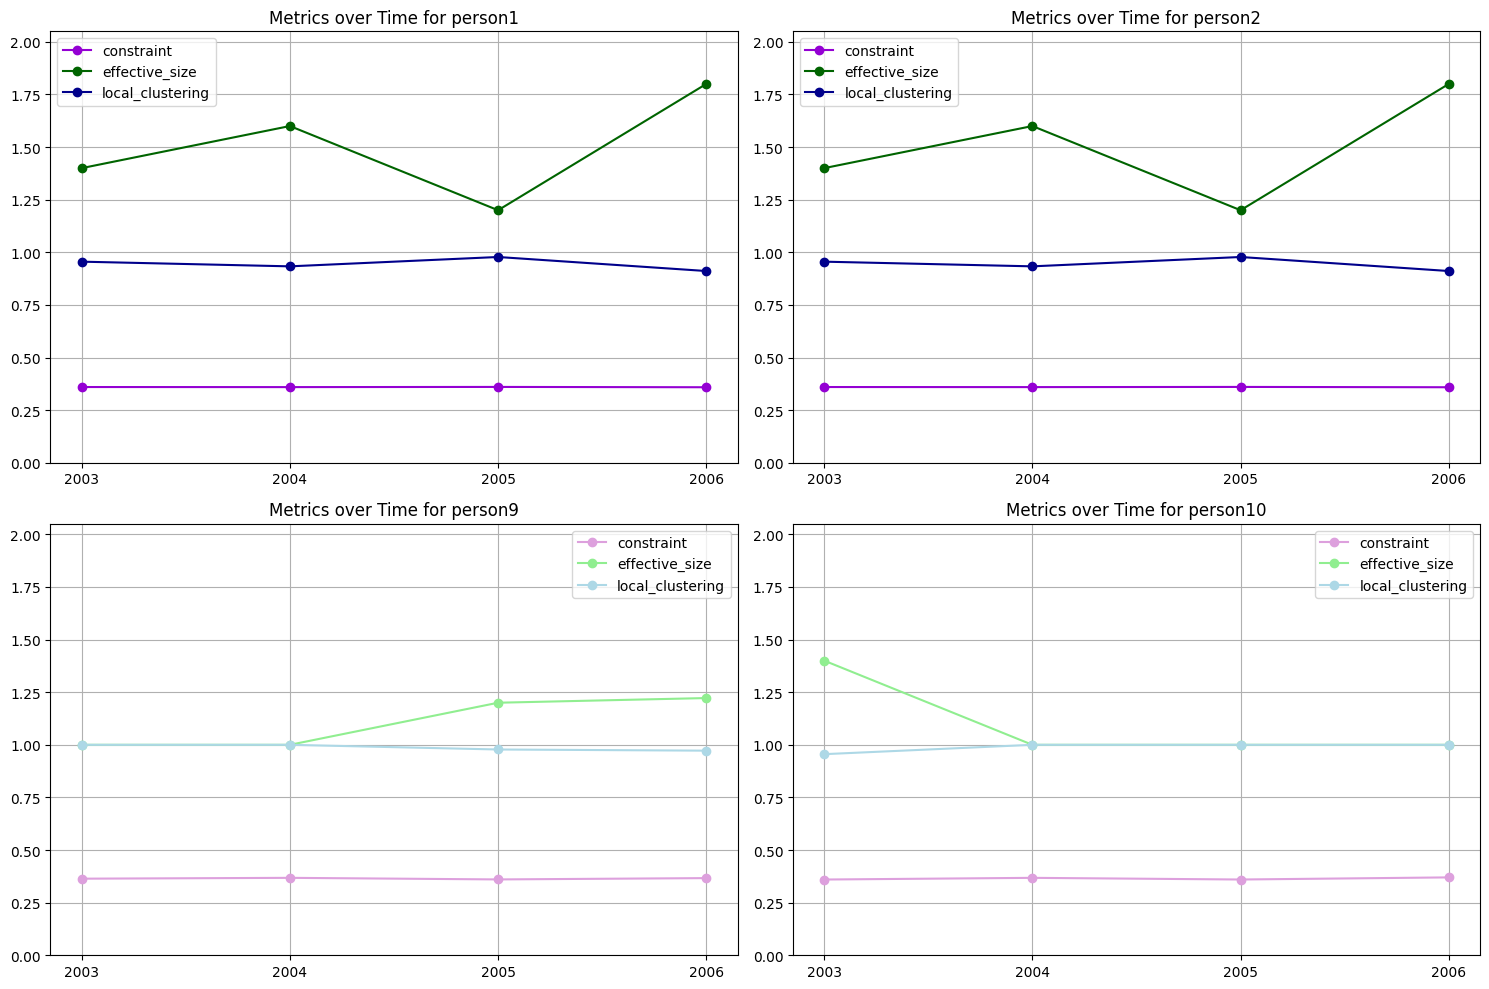

In [21]:
# Define the years and metrics
years = sorted(brokerage_scores_by_year_toy.keys())
metrics = ['constraint', 'effective_size', 'local_clustering']

# Prepare data for visualization
person_data = {person: {metric: [] for metric in metrics} for person in ['person1', 'person2', 'person9', 'person10']}
for year in years:
    year_data = brokerage_scores_by_year_toy[year]
    for person in ['person1', 'person2', 'person9', 'person10']:
        for metric in metrics:
            person_data[person][metric].append(year_data[metric].get(person, None))

# Define color mapping for the metrics with intensity variations
color_map = {
    'constraint': {'intense': 'darkviolet', 'light': 'plum'},
    'effective_size': {'intense': 'darkgreen', 'light': 'lightgreen'},
    'local_clustering': {'intense': 'darkblue', 'light': 'lightblue'}
}

# Find the max across all metrics for y-axis normalization
max_val = max(max(person_data[person][metric]) for person in person_data for metric in metrics)

# Plotting configuration for side-by-side comparisons
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns
intense_persons = ['person1', 'person2']
light_persons = ['person9', 'person10']
axis_map = {0: 'person1', 1: 'person2', 2: 'person9', 3: 'person10'}

for idx, ax in enumerate(axs.flatten()):
    person = axis_map[idx]
    for metric in metrics:
        if person in intense_persons:
            color = color_map[metric]['intense']
        else:
            color = color_map[metric]['light']
        
        ax.plot(years, person_data[person][metric], label=metric, color=color, marker='o')
    ax.set_title(f'Metrics over Time for {person}')
    ax.set_ylim([0, max_val + 0.25])  # Start y-axis at 0 and normalize to max value across all plots
    ax.legend()
    ax.grid(True)
    ax.set_xticks(years)  # Ensure x-axis labels are years without decimals

plt.tight_layout()
plt.show()


In our simulation, we placed Person 1 and Person 3 in more movies than others, expecting this would make them central connectors in our network. However, the results didn't match our expectations. Both ended up having similar constraint and local clustering as Person 9 and Person 10. This similarity is not by chance but by design.

That is, our setup involved just 11 people, each collaborating in many projects every year. This created a very interconnected group, where everyone was closely linked to everyone else. In such tight networks, it's difficult for individuals to act as bridges between different groups or to have unique information that others don't, even when they work on more movies than everyone else.

Additionally, even though we mixed up the team members randomly, they often ended up working in similar patterns. This repetition made everyone's role in the network quite similar, blurring any special status we hoped to see in our key players.

However, when we looked at 'effective size'—a count of meaningful, unique connections each person had—we started seeing clearer differences. This measure helped us identify who really had more diverse contacts within our simulation.

It should be noted that this scenario of everyone being so closely connected is very rare in real life collaborations. Speaking of which, we're now ready to analyze our real-world data from actual movie collaborations!

## Applying the functions to the real dataset

Now, we shift our focus to the real-world data: the `movies_collaborations_2000_2023` dataset. It captures the collaborative ties among creative individuals in the film industry from 2000 to 2023. Leveraging the power of parallel processing, we concurrently compute brokerage social capital scores for every individual each between 2003 and 2023.

The results of these computations are compiled organized into a dictionary, `brokerage_scores_by_year`. This structure pairs each year—starting from 2003—with a set of brokerage social capital metrics ("constraint", "effective size", and "local clustering"). Each creative worker in the network is uniquely identified by a code (`nconst`), linking them directly to their annual brokerage scores.

To ensure these complex data structures are preserved accurately for future analysis, we store the dictionary as `brokerage_scores_by_year.pkl`. Utilizing Python’s pickle format is optimal for managing such intricate data structures, ensuring they are easily accessible for ongoing and future studies.

In [ ]:
# Apply the same process to the actual dataset of movie collaborations
# Load the real dataset containing movie collaborations from 2000 to 2023
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

from parallel_functions import calculate_social_capital_wrapper 

def create_pairs(group):
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

if __name__ == "__main__":
    # Group the real dataset by movie and year, and create pairs of collaborators
    movies_collaborations_2000_2023 = movies_collaborations_2000_2023.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year 
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in movies_collaborations_2000_2023.groupby('startYear')}

    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process
    years = range(2003, 2024)
    
    # Calculate brokerage scores for each year in parallel 
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Collect the calculated brokerage scores by year 
    brokerage_scores_by_year = {year: scores for year, scores in results}
    
    # Save the calculated brokerage scores as a pickle file for future use
    with open('brokerage_scores_by_year.pkl', 'wb') as f:
        pickle.dump(brokerage_scores_by_year, f)

In [5]:
# Checking the contents and structure of the data

# Print the dictionary keys, which are the years for which data is available.
# This is to ensure the data covers the expected timeframe.
print("Years in the dataset:", list(brokerage_scores_by_year.keys()))

Years in the dataset: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [6]:
# Check the structure of a nested dictionary by picking a sample year
sample_year = next(iter(brokerage_scores_by_year))  # Get the first year in the dictionary
# Print the keys of the nested dictionary for the first year in the data, which are the types of brokerage scores available.
print(f"Brokerage score types available in {sample_year}:", list(brokerage_scores_by_year[sample_year].keys()))

Brokerage score types available in 2003: ['constraint', 'effective_size', 'local_clustering']


In [7]:
# Pick one type of score to sample, for example 'constraint'
score_type = 'constraint'
# Sample 10 random IDs within the 'constraint' scores
sample_ids = random.sample(list(brokerage_scores_by_year[sample_year][score_type].keys()), 10)
# Print the constraint scores for the randomly selected people
print(f"Random sample of {score_type} scores for {sample_year}:")
for nconst in sample_ids:
        print(f"ID {nconst}: {brokerage_scores_by_year[sample_year][score_type][nconst]}")

Random sample of constraint scores for 2003:
ID nm1516921: 0.925925925925926
ID nm3823083: 1.125
ID nm1178382: 0.5236734693877553
ID nm0829044: 0.14983323429927986
ID nm14765105: 1.0
ID nm0129515: 0.571825
ID nm9885971: 0.45350059171597645
ID nm0959197: 0.7218651158045097
ID nm0074404: 0.462962962962963
ID nm0001952: 0.4169136094674556


Everything looks great! The scores we calculated are organized as a dictionary where each key corresponds to a year (e.g., 2003, 2004, etc.), and the associated value is another dictionary. This nested structure maps people's IDs (`nconst`) to their brokerage scores, which are divided into three categories: constraint, effective size, and local clustering. Within this hierarchy, each brokerage score type leads to another dictionary where the keys are the unique identifiers `nconst` for individuals in the network, and the values are the scores themselves. This arrangement allows for efficient querying of individual scores across different years and types.

Think of the data as a set of filing cabinets, where each cabinet is dedicated to a specific year. Inside each cabinet, there are several folders, each labeled according to the type of brokerage scores it contains—such as "constraint," "effective size," or "local clustering." Each folder is filled with individual files; each file pertains to a specific person, identified by a unique ID (`nconst`). The information in the file is the person's score for that specific type of brokerage during that year.

If we want to find out a person’s score for a certain type of relationship metric in a given year, we would first choose the correct year's cabinet, select the folder for the score type we are interested in, and then find the file labeled with the person’s ID. In future analyses, we can use this file to get the yearly brokerage scores of the directors and their collaborators.